In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val/Tinea Ringworm Candidiasis/aug_0_nejmicm1013871_f1.jpeg
/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val/Tinea Ringworm Candidiasis/aug_0_Direct-microscopic-examination-revealed-endothrix-infection-with-chains-of-conidia-in-and_Q320.jpg
/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val/Tinea Ringworm Candidiasis/aug_0_jock-itch-1024x683.jpeg
/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val/Tinea Ringworm Candidiasis/aug_0_dermatomycosis-corporis-3.jpg
/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val/Tinea Ringworm Candidiasis/aug_0_natural-treatment-Daad-khaj-khujli-ringworm-home-treatment-home-remedies-fungal-infection-treatment-symptom-pictures-diagnosis-hindi-gimtrend.blogspot.com.jpeg
/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val/Tinea Ringworm Candidiasis/aug_0_B9780702044496000291_f029-001-9780702044

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

train_dataset = datasets.ImageFolder('/kaggle/input/skin-disease-classification-image-dataset/Split_smol/train', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/input/skin-disease-classification-image-dataset/Split_smol/val', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle=False)

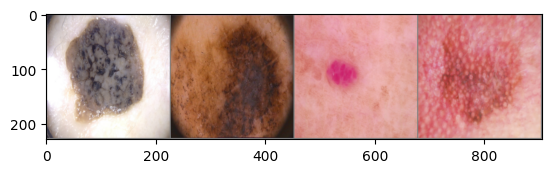

Benign Keratosis Melanoma Valcular Lesion Actinic Keratosis


In [5]:
classes = ['Actinic Keratosis', 'Atopic Dermatitis', 'Benign Keratosis', 'Dermatofibroma',
          'Melanocytic Nevus', 'Melanoma', 'Squamous Cell Carcinoma', 'Tinea Ringworm Candidiasis',
          'Valcular Lesion']
def imshow(img):
    img = img/2 + 0.5
    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [6]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
num_classes = 9
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 38.2MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [8]:
train_losses = []
val_losses = []
best_loss = float('inf')  # Initialize with a high value
patience = 5  # Stop training if the validation loss doesn't improve for 5 consecutive epochs
counter = 0
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    model.eval()
    val_loss = 0.0
    for data, target in validation_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()

    val_loss /= len(validation_loader)

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0  # Reset the counter if there's an improvement
        # Save the model checkpoint if needed
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
    
    train_losses.append(running_loss/ len(train_loader))
    val_losses.append(val_loss)
    print(f'Epoch: {epoch + 1} - Training Loss: {running_loss/ len(train_loader)}')
    print(f"Epoch [{epoch + 1}/{num_epochs}] Validation Loss: {val_loss}")

    # Early stopping condition
    if counter >= patience:
        print(f"No improvement for {patience} epochs. Early stopping!")
        break  # Stop training

Epoch: 1 - Training Loss: 1.8514126985413688
Epoch [1/10] Validation Loss: 1.3695359184690143
Epoch: 2 - Training Loss: 1.2973801670755658
Epoch [2/10] Validation Loss: 0.8876555015778412
Epoch: 3 - Training Loss: 1.1206039830190795
Epoch [3/10] Validation Loss: 0.8149699247644647
Epoch: 4 - Training Loss: 1.1341605892777442
Epoch [4/10] Validation Loss: 0.9035960047141366
Epoch: 5 - Training Loss: 0.9482666861159461
Epoch [5/10] Validation Loss: 0.8235045785600643
Epoch: 6 - Training Loss: 0.9809202258075986
Epoch [6/10] Validation Loss: 0.7689979289982306
Epoch: 7 - Training Loss: 0.9523172618022987
Epoch [7/10] Validation Loss: 0.7008043789132701
Epoch: 8 - Training Loss: 1.0610622813552617
Epoch [8/10] Validation Loss: 0.7296201665835131
Epoch: 9 - Training Loss: 0.865697566483702
Epoch [9/10] Validation Loss: 0.6824546410757846
Epoch: 10 - Training Loss: 0.9669422496216638
Epoch [10/10] Validation Loss: 0.904975639210771


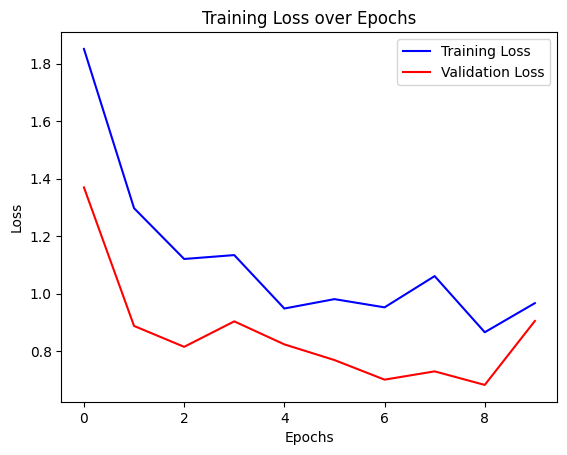

In [9]:
plt.plot(train_losses, color='blue', label='Training Loss')
plt.plot(val_losses, color='red', label='Validation Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 75.69060773480663%


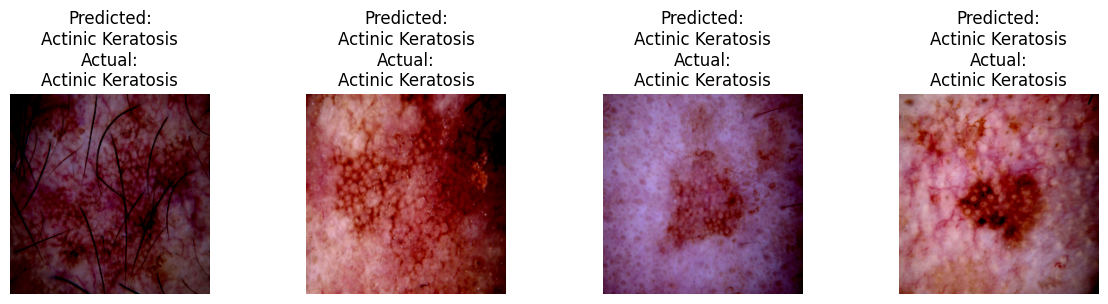

In [11]:
class_labels = {0: 'cats', 1: 'dogs'}

model.eval()

images, labels = next(iter(validation_loader))

images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

num_images = len(images)
num_rows = num_images // 4  # Calculate the number of rows for subplots

fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:  # Ensure the image index is within the available range
        image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
        ax.imshow(image)
        predicted_label = classes[predicted[i].item()]
        actual_label = classes[labels[i].item()]

        ax.set_title(f'Predicted:\n{predicted_label}\nActual:\n{actual_label}')
        ax.axis('off')

plt.tight_layout()
plt.show()

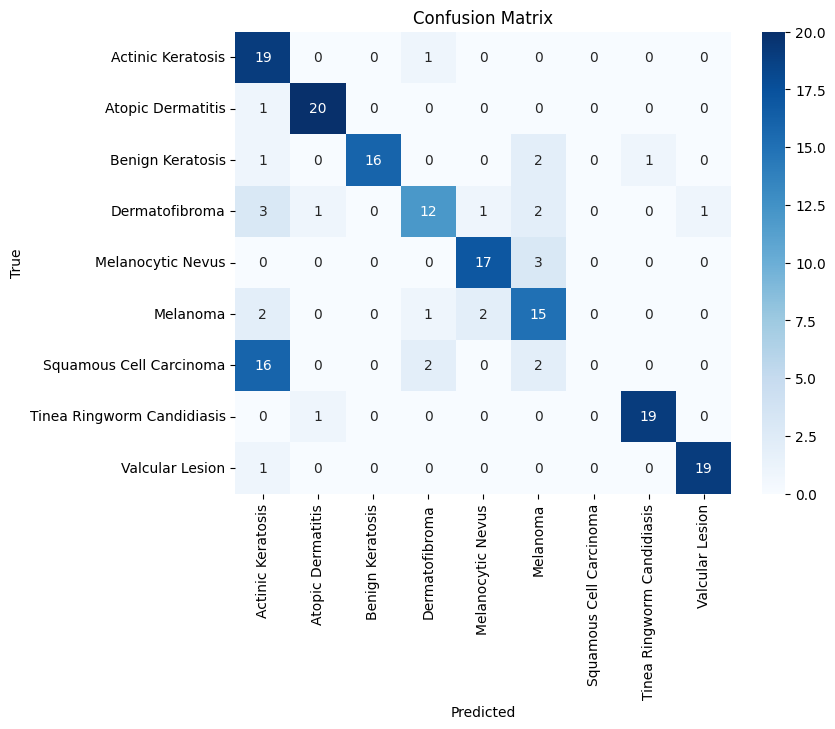

In [12]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()